<a href="https://colab.research.google.com/github/bjelikj/Checkers/blob/master/final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
#!rm features.py
#!rm constants.py
#!rm load_csv_data.py
#!rm loader.py
!ls

drive  sample_data


In [2]:
from google.colab import files
files.upload()

Saving constants.py to constants.py
Saving features.py to features.py
Saving load_csv_data.py to load_csv_data.py
Saving loader.py to loader.py


{'constants.py': b'# Run locally\n"""\nDATASETS = "Datasets/fma_small/"\nMETADATA = "Datasets/fma_metadata/"\nMFCC = "Datasets/mfcc.csv"\nSPECTROGRAM = "Datasets/spectrogram.csv"\nSPECTROGRAM_AUGMENT = "Datasets/spectrogram_augment_6.csv"\nAUGMENT = True\n"""\n# # Run on Google Colab\nDATASETS = "/content/drive/My Drive/Datasets/fma_small/"\nMETADATA = "/content/drive/My Drive/Datasets/fma_metadata/"\nMFCC = "/content/drive/My Drive/Datasets/mfcc.csv"\nSPECTROGRAM = "/content/drive/My Drive/Datasets/spectrogram.csv"\nSPECTROGRAM_AUGMENT = "/content/drive/My Drive/Datasets/spectrogram_augment.csv"\n\n\n# spectrogram_augment_1.csv: time stretch, rate=1.1\n# spectrogram_augment_2.csv: pitch shift, n_steps=2\n# spectrogram_augment_3.csv: time stretch, rate=0.9\n# spectrogram_augment_4.csv: sampling different 3s from dataset\n# spectrogram_augment_5.csv: pitch shift, n_steps=-2\n\n"""\nTODO:\n    Try rectangular filters\n    no augmentation on val and test\n    add dropout, batchnormalizati

In [0]:
import loader
import load_csv_data
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
# Load original dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram.csv")

# Load augmented dataset (pitch shift, n_steps=2)
(x_train_aug_2, y_train_aug_2), (x_val_aug_2, y_val_aug_2), (x_test_aug_2, y_test_aug_2) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_2.csv")

# Load augmented dataset (time stretch, rate=0.9)
(x_train_aug_3, y_train_aug_3), (x_val_aug_3, y_val_aug_3), (x_test_aug_3, y_test_aug_3) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_3.csv")

# Load augmented dataset (different 3s of tracks sampled)
(x_train_aug_4, y_train_aug_4), (x_val_aug_4, y_val_aug_4), (x_test_aug_4, y_test_aug_4) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_4.csv")

# Load augmented dataset (pitch shift, n_steps=-2)
(x_train_aug_5, y_train_aug_5), (x_val_aug_5, y_val_aug_5), (x_test_aug_5, y_test_aug_5) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_5.csv")

# Load augmented dataset (different 3s, time stretch, rate=1.1)
(x_train_aug_6, y_train_aug_6), (x_val_aug_6, y_val_aug_6), (x_test_aug_6, y_test_aug_6) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_6.csv")

In [0]:
# Stack datasets
x_train = np.hstack((x_train, x_train_aug_2, x_train_aug_3, x_train_aug_4, x_train_aug_5, x_train_aug_6))
y_train = np.hstack((y_train, y_train_aug_2, y_train_aug_3, y_train_aug_4, y_train_aug_5, y_train_aug_6))
#x_val = np.hstack((x_val, x_val_aug_4))
#x_test = np.hstack((x_test, x_test_aug_4))
#y_val = np.hstack((y_val, y_val_aug_4))
#y_test = np.hstack((y_test, y_test_aug_4))

In [0]:
x_train = np.rollaxis(np.dstack(x_train), -1)
x_val = np.rollaxis(np.dstack(x_val), -1)
x_test = np.rollaxis(np.dstack(x_test), -1)

In [0]:
x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [0]:
dict_labels = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3,
                   'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
y_train = [dict_labels[y_train[i]] for i in range(y_train.shape[0])]
y_val = [dict_labels[y_val[i]] for i in range(y_val.shape[0])]
y_test = [dict_labels[y_test[i]] for i in range(y_test.shape[0])]

In [0]:
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)
y_test_one_hot = to_categorical(y_test, num_classes=8)

In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

In [0]:
def build_model(input_shape):
  X_input = layers.Input(input_shape)

  X = layers.Conv2D(32, (5, 5), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X1 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
  X1 = layers.BatchNormalization()(X1)

  b1 = layers.MaxPool2D((2, 2))(X) 
  b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.Activation('relu')(b1)
  b1 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)

  X = layers.Add()([X1, b1])
  X = layers.Activation('relu')(X)

  X1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
  X1 = layers.BatchNormalization()(X1)

  b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.Activation('relu')(b1)
  b1 = layers.Conv2D(128, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)

  X = layers.Add()([X1, b1])
  X = layers.Activation('relu')(X)

  X2 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
  X2 = layers.BatchNormalization()(X2)

  b2 = layers.MaxPool2D((2, 2))(X) 
  b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.Activation('relu')(b2)
  b2 = layers.Conv2D(256, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)


  X = layers.Add()([X2, b2])
  X = layers.Activation('relu')(X)

  X2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(X)
  X2 = layers.BatchNormalization()(X2)

  b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.Activation('relu')(b2)
  b2 = layers.Conv2D(128, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)

  X = layers.Add()([X2, b2])
  X = layers.Activation('relu')(X)

  X3 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
  X3 = layers.BatchNormalization()(X3)

  b3 = layers.MaxPool2D((2, 2))(X) 
  b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.Activation('relu')(b3)
  b3 = layers.Conv2D(64, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)


  X = layers.Add()([X3, b3])
  X = layers.Activation('relu')(X)

  X3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(X)
  X3 = layers.BatchNormalization()(X3)

  b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.Activation('relu')(b3)
  b3 = layers.Conv2D(128, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)



  X = layers.Flatten()(X)
  X = layers.Dense(128, kernel_initializer='he_uniform')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.Dense(8, kernel_initializer='he_uniform')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('softmax')(X)

  model = tf.keras.models.Model(inputs=X_input, outputs=X, name='model_8')
  model.summary()

  return model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

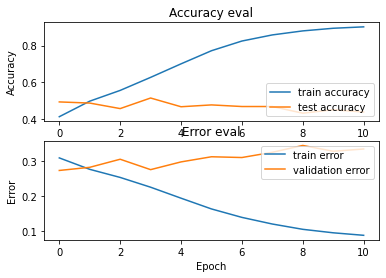

In [10]:
lr = 2e-4
epochs = 30
batch_size = 16

model = build_model((128, 128, 1))
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks: early stopping and checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,
                               patience=7,
                               mode='max',
                               restore_best_weights=True)

filepath = "/content/drive/My Drive/Models/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [early_stopping, checkpoint]
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) // batch_size,
                    callbacks=callbacks_list,
                    epochs=epochs, verbose=1)


plot_history(history)

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test_one_hot, batch_size=batch_size)
print("Test loss:", results[0])
print("Test acc:", results[1])

y_test_pred = np.argmax(model.predict(x_test), axis=1)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification reprot:")
print(classification_report(y_test, y_test_pred, digits=8))

Evaluating model on test data...
50/50 [==============================] - 0s 6ms/step - loss: 0.2793 - accuracy: 0.5025
Test loss: 0.2792723476886749
Test acc: 0.5024999976158142
Confusion matrix:
[[58  5  4 11  5  3  9  5]
 [ 6 39 13  9 10  5  9  9]
 [ 2 18 53  0  6 10  7  4]
 [15  3  5 67  2  3  3  2]
 [ 8 18 25  0 41  0  8  0]
 [13  4 16  5  4 48  7  3]
 [17  7 17  8  5  8 28 10]
 [ 5  9  7  1  0  3  7 68]]
Classification reprot:
              precision    recall  f1-score   support

           0  0.46774194 0.58000000 0.51785714       100
           1  0.37864078 0.39000000 0.38423645       100
           2  0.37857143 0.53000000 0.44166667       100
           3  0.66336634 0.67000000 0.66666667       100
           4  0.56164384 0.41000000 0.47398844       100
           5  0.60000000 0.48000000 0.53333333       100
           6  0.35897436 0.28000000 0.31460674       100
           7  0.67326733 0.68000000 0.67661692       100

    accuracy                      0.50250000       

In [0]:
# Big model + RNN

def build_model_CNN_RNN_BIG(input_shape):
    X_input = layers.Input(input_shape)

    X = layers.Conv2D(32, (5, 5), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)

    X1 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
    X1 = layers.BatchNormalization()(X1)

    b1 = layers.MaxPool2D((2, 2))(X) 
    b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(128, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
    b1 = layers.BatchNormalization()(b1)

    X = layers.Add()([X1, b1])
    X = layers.Activation('relu')(X)

    X1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
    X1 = layers.BatchNormalization()(X1)

    b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
    b1 = layers.BatchNormalization()(b1)

    X = layers.Add()([X1, b1])
    X = layers.Activation('relu')(X)

    X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
    X2 = layers.BatchNormalization()(X2)

    b2 = layers.MaxPool2D((2, 2))(X) 
    b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
    b2 = layers.BatchNormalization()(b2)


    X = layers.Add()([X2, b2])
    X = layers.Activation('relu')(X)

    X2 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(X)
    X2 = layers.BatchNormalization()(X2)

    b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
    b2 = layers.BatchNormalization()(b2)

    X = layers.Add()([X2, b2])
    X = layers.Activation('relu')(X)

    X3 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
    X3 = layers.BatchNormalization()(X3)

    b3 = layers.MaxPool2D((2, 2))(X) 
    b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)
    b3 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
    b3 = layers.BatchNormalization()(b3)


    X = layers.Add()([X3, b3])
    X = layers.Activation('relu')(X)

    X3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(X)
    X3 = layers.BatchNormalization()(X3)

    b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)
    b3 = layers.Conv2D(128, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
    b3 = layers.BatchNormalization()(b3)

    X = layers.Add()([X3, b3])
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPool2D((2, 2))(X)

    X = layers.Flatten()(X)

    ##### Recurrent Block #####

    # Pooling layer
    R = MaxPooling2D((1, 2), strides=(1, 2), name='pool_lstm')(X_input)

    # Embedding layer
    squeezed = layers.Lambda(lambda x: tf.keras.backend.squeeze(x, axis=-1))(R)
    #flatten2 = K.squeeze(pool_lstm1, axis = -1)
    #dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = layers.Bidirectional(layers.GRU(64))(squeezed)
    

    ##### Concatenate blocks #####
    # Concat Output
    concat = layers.concatenate([X, lstm], axis=-1, name='concat') #TODO: add?
    
    ## Softmax Output
    output = Dense(8, activation='softmax', name='preds')(concat)
    
    model_output = output
    model = tf.keras.models.Model(X_input, model_output)
    
    opt = Adam(lr=0.001)
    #opt = tf.keras.optimizers.RMSprop(lr=0.0005)  # Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [12]:
model = build_model_CNN_RNN_BIG((128, 128, 1))
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Models/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,
                               patience=20,
                               mode='max',
                               restore_best_weights=True)
callbacks_list = [checkpoint_callback, early_stopping]

history = model.fit(x_train, y_train, batch_size=32, epochs=50,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 64, 64, 32)   128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 64, 64, 32)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [13]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test_one_hot)
print("Test loss:", results[0])
print("Test acc:", results[1])

y_test_pred = np.argmax(model.predict(x_test), axis=1)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification reprot:")
print(classification_report(y_test, y_test_pred, digits=8))

Evaluating model on test data...
25/25 [==============================] - 0s 20ms/step - loss: 1.3643 - accuracy: 0.5250
Test loss: 1.3643012046813965
Test acc: 0.5249999761581421
Confusion matrix:
[[68  8  7  4  8  4  1  0]
 [12 45  9  1 17 10  2  4]
 [ 0 17 65  0  3 11  3  1]
 [13  8  1 71  0  6  1  0]
 [ 8 24 26  1 37  2  0  2]
 [ 7  2 14  5  2 63  6  1]
 [24  7 17  7  3 20 17  5]
 [11 13  7  1  3  7  4 54]]
Classification reprot:
              precision    recall  f1-score   support

           0  0.47552448 0.68000000 0.55967078       100
           1  0.36290323 0.45000000 0.40178571       100
           2  0.44520548 0.65000000 0.52845528       100
           3  0.78888889 0.71000000 0.74736842       100
           4  0.50684932 0.37000000 0.42774566       100
           5  0.51219512 0.63000000 0.56502242       100
           6  0.50000000 0.17000000 0.25373134       100
           7  0.80597015 0.54000000 0.64670659       100

    accuracy                      0.52500000      

In [0]:
def build_model_CRNN(model_input):
    X_input = layers.Input(model_input)
    
    ##### Convolutional blocks #####
    # First convolutional block
    X = Conv2D(68, (3, 3), strides=(1, 1), padding='same', name='conv_1')(X_input)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(1, 1))(X)
    X = Dropout(0.1)(X)

    # Second convolutional block
    X = Conv2D(137, (3, 3), strides=(1, 1), padding='same', name='conv_2')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)
    X = Dropout(0.1)(X)

    # Third convolutional block
    X = Conv2D(137, (3, 3), strides=(1, 1), padding='same', name='conv_3')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((4, 4), strides=(1, 1))(X)
    X = Dropout(0.1)(X)

    # Fourth convolutional block
    X = Conv2D(137, (3, 3), strides=(1, 1), padding='same', name='conv_4')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((4, 4), strides=(1, 1))(X)
    X = Dropout(0.1)(X)

    ##### Recurrent Block #####
    
    # GRU layer
    lstm = layers.GRU(68)(X[:, :, :, 0])

    ## Softmax Output
    output = Dense(8, activation='softmax', name='preds')(lstm)
    
    model_output = output
    model = tf.keras.models.Model(X_input, model_output)
    
    opt = Adam(lr=0.001)
    #opt = tf.keras.optimizers.RMSprop(lr=0.0005)  # Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [14]:
model = build_model_CRNN((128, 128, 1))
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Models/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)
callbacks_list = [checkpoint_callback, early_stopping]

history = model.fit(x_train, y_train, batch_size=32, epochs=30,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 68)      680       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 68)      272       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 68)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 68)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 68)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 127, 127, 137)     83981 

ValueError: ignored

In [15]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test_one_hot)
print("Test loss:", results[0])
print("Test acc:", results[1])

y_test_pred = np.argmax(model.predict(x_test), axis=1)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification reprot:")
print(classification_report(y_test, y_test_pred, digits=8))

Evaluating model on test data...
25/25 [==============================] - 6s 257ms/step - loss: 1.6591 - accuracy: 0.4038
Test loss: 1.6590604782104492
Test acc: 0.4037500023841858
Confusion matrix:
[[55  3  9 14  5  9  1  4]
 [19 15 15  6 15 14  4 12]
 [ 1  6 42  0 13 32  2  4]
 [24  4  1 60  1  9  0  1]
 [ 4  9 35  1 41  9  1  0]
 [ 9  3 18  7  3 53  2  5]
 [36  6 16  6  4 21  8  3]
 [ 6 10  8  4  2 15  6 49]]
Classification reprot:
              precision    recall  f1-score   support

           0  0.35714286 0.55000000 0.43307087       100
           1  0.26785714 0.15000000 0.19230769       100
           2  0.29166667 0.42000000 0.34426230       100
           3  0.61224490 0.60000000 0.60606061       100
           4  0.48809524 0.41000000 0.44565217       100
           5  0.32716049 0.53000000 0.40458015       100
           6  0.33333333 0.08000000 0.12903226       100
           7  0.62820513 0.49000000 0.55056180       100

    accuracy                      0.40375000     

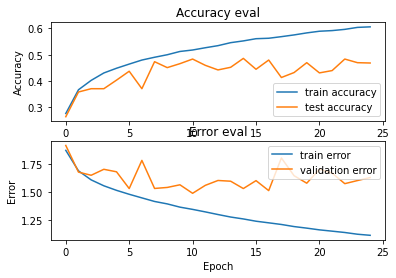

In [20]:
plot_history(history)